# Computing temperature, salinity and mixing length for the SR1b section data

In [1]:
import pickle
import h5py
import numpy as np
import xarray as xr
from scipy.io import loadmat
import gsw
import csaps
import warnings

## Read in data, compute SA, CT, $\phi_{1500}$

In [2]:
#%% READ IN HYDROGRAPHIC SECTION DATA
data = loadmat('data/SR1b_section/sr1b_all.mat')

icyc = np.where(data['buf_year'] != 1999)[1] # exclude 1999

buf_lat = data['buf_lat'][0,icyc]
buf_lon = data['buf_lon'][0,icyc]
buf_sal = data['buf_sal'][:,icyc]
buf_temp = data['buf_temp'][:,icyc]
buf_ptmp = data['buf_ptmp'][:,icyc]
buf_press = data['buf_press'].reshape(3000)
buf_year = data['buf_year'][:,icyc].reshape(316)

f = h5py.File('data/SR1b_section/sr1b_gamma.mat')
buf_gamma = f["gamma"][icyc,:].transpose()

In [3]:
# sample points along section
start_lon_vals = []
end_lon_vals = []
start_lat_vals = []
end_lat_vals = []
for yr in np.unique(buf_year):
  idx_yr = np.where(buf_year == yr)[0]
  start_lon_vals.append(np.min(buf_lon[idx_yr]))
  end_lon_vals.append(np.max(buf_lon[idx_yr]))
  start_lat_vals.append(np.max(buf_lat[idx_yr]))
  end_lat_vals.append(np.min(buf_lat[idx_yr]))
start_lon = np.mean(np.array(start_lon_vals))
end_lon = np.mean(np.array(end_lon_vals))
start_lat = np.mean(np.array(start_lat_vals))
end_lat = np.mean(np.array(end_lat_vals))

# Extract unique points along the section
nr_points = 30
lon_along_section = np.linspace(start_lon, end_lon, nr_points)
lat_along_section = np.linspace(start_lat, end_lat, nr_points)

# calculate distance from southern end of section
dist_along_section = np.zeros(len(lat_along_section))
for i in range(len(dist_along_section)):
  dist_along_section[i] = gsw.distance(np.mean(lon_along_section)*np.ones(2), np.array([min(lat_along_section), lat_along_section[i]]))[0]

# fit smoothing spline through relationship between distance and latitude/longitude along section
pp_dist_lat = csaps.csaps(dist_along_section[::-1], lat_along_section[::-1], smooth=0.85)
pp_lat_lon = csaps.csaps(lat_along_section[::-1], lon_along_section[::-1], smooth=0.85)
# save the spline fit
with open('data/pp_dist_lat.pkl', 'wb') as f:
    pickle.dump(pp_dist_lat, f)
with open('data/pp_lat_lon.pkl', 'wb') as f:
    pickle.dump(pp_lat_lon, f)

/nethome/5664187/miniconda3/envs/carlo/lib/python3.13/site-packages/csaps/_sspumv.py:301: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(a, b)


In [4]:
# calculate absolute salinity and conservative temperature
buf_SA = gsw.SA_from_SP(buf_sal, buf_press.reshape(3000,1), buf_lon.reshape(1,316), buf_lat.reshape(1,316)) # absolute salinity
buf_CT = gsw.conversions.CT_from_t(buf_SA, buf_temp, buf_press.reshape(3000,1)) # conservative temperature

# compute baroclinic streamfunction
gpan_buf = -gsw.geo_strf_dyn_height(buf_SA, buf_CT, buf_press, 1500) #geopotential height anomaly / dynamic height anomalyß
buf_phi1500 = abs(gpan_buf[249,:]) # index 250 is at 500 dbar

# calculate distance from southern end of section
buf_dist = np.zeros(len(buf_lat))
for i in range(len(buf_lat)):
  buf_dist[i] = gsw.distance(np.mean(buf_lon)*np.ones(2), np.array([min(buf_lat), buf_lat[i]]))[0]

# fit a smoothing spline through relationship
pp_dist = csaps.csaps(buf_phi1500[np.argsort(buf_phi1500)[:-np.count_nonzero(np.isnan(buf_phi1500))]],
                      buf_dist[np.argsort(buf_phi1500)[:-np.count_nonzero(np.isnan(buf_phi1500))]],
                      smooth = 0.85)

# apply fitted spline for current data
distfromphi = pp_dist(buf_phi1500)

In [35]:
# subsample points at specific depths
sub = 75
buf_press_sub = buf_press[::sub]
buf_SA_sub = buf_SA[::sub,:]
buf_CT_sub = buf_CT[::sub,:]
buf_gamma_sub = buf_gamma[::sub,:]

## Linear interpolation of variables on desired neutral surfaces

In [36]:
win_width = 0.02
igamma = np.arange(27.14, 28.21, win_width)
surf_press = np.zeros((len(igamma),len(buf_lat)))
surf_CT = np.zeros((len(igamma),len(buf_lat)))
surf_SA = np.zeros((len(igamma),len(buf_lat)))

for j in range(len(buf_lat)):
    with warnings.catch_warnings(): # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
        for i in range(len(igamma)):
            icyc = np.where((buf_gamma_sub[:,j] <= igamma[i] + win_width/2) & (buf_gamma_sub[:,j] >= igamma[i] - win_width/2))[0]
            surf_press[i,j] = np.nanmean(buf_press_sub[icyc])
            surf_CT[i,j] = np.nanmean(buf_CT_sub[icyc,j])
            surf_SA[i,j] = np.nanmean(buf_SA_sub[icyc,j])

In [37]:
# remove data entries that are not within the distfromphi range of the moorings before making spline fits
phi_min = 5.48 # minimum distfromphi based on mooring data
section_exclude = np.where(buf_phi1500 < phi_min)[0]
surf_press[:,section_exclude] = np.nan
surf_CT[:,section_exclude] = np.nan
surf_SA[:,section_exclude] = np.nan

## Calculate mean and rms of temperature and salinity plus their gradients on each neutral surface

In [38]:
# fit splines on isoneutral surfaces to determine mean relationships
pp_CT = [[] for i in range(len(igamma))]  # initialize array to fill with spline fits
pp_SA = [[] for i in range(len(igamma))]

for j in range(len(igamma)):  # only rows where there are actually non-NaNs, see surf_CT[77,:][~np.isnan(surf_CT[77,:])]
    # fit a smoothing spline through relationship
    idx_x = np.argsort(distfromphi)[:-np.count_nonzero(np.isnan(distfromphi))] # non-nan indices in x (for spline fit)
    idx_y = np.argwhere(~np.isnan(surf_CT[j,:])) #non-nan indices in y      

    new_idx = []
    for i in range(len(idx_x)):
        if idx_x[i] in idx_y:
            new_idx.append(idx_x[i])
    new_idx = np.asarray(new_idx)      

    # now do spline fit, smoothing factor is rather arbitrary
    smooth = 1e-14
    pp_CT[j] = csaps.csaps(distfromphi[new_idx], surf_CT[j,:][new_idx], smooth=smooth)
    pp_SA[j] = csaps.csaps(distfromphi[new_idx], surf_SA[j,:][new_idx], smooth=smooth)

/nethome/5664187/miniconda3/envs/carlo/lib/python3.13/site-packages/csaps/_sspumv.py:301: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(a, b)


In [39]:
# calculate "background" meridional theta gradient and rms theta anomaly for each isopycnal using a running meridional window

# define a meridional distance grid, and the width of the running window
idist = np.arange(390e3,680e3,10e3)
win_width = 40e3

pressmean     = np.zeros((len(igamma), len(idist)))
SAbar         = np.zeros((len(igamma), len(idist)))
thetabar      = np.zeros((len(igamma), len(idist)))
dthetabardy   = np.zeros((len(igamma), len(idist)))
rms_theta     = np.zeros((len(igamma), len(idist)))

for j in range(len(igamma)):
    dthetabardy[j,:] = np.gradient(pp_CT[j](idist),idist)
    with warnings.catch_warnings(): # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
        for i in range(len(idist)):
            icyc = np.where((distfromphi <= idist[i] + win_width/2) & (distfromphi >= idist[i] - win_width/2))[0]

            pressmean[j,i] = np.nanmean(surf_press[j,icyc])
            thetabar[j,i] = pp_CT[j](idist[i])
            SAbar[j,i]    = pp_SA[j](idist[i])

            if len(icyc) == 1:
                rms_theta[j,i] = abs(surf_CT[j,icyc] - pp_CT[j](distfromphi[icyc]))
            elif len(icyc) > 1:
                rms_theta[j,i] = np.nanstd(surf_CT[j,icyc] - pp_CT[j](distfromphi[icyc]))
            else:
                rms_theta[j,i] = np.nan

SAbar[np.isnan(pressmean)] = np.nan
thetabar[np.isnan(pressmean)] = np.nan
dthetabardy[np.isnan(pressmean)] = np.nan
rms_theta[np.isnan(pressmean)] = np.nan

## Calculate mixing length

In [40]:
# mixing efficiency parameter
gamma_mix = 0.35

# based on temperature
dthetabardy_limited = dthetabardy.copy()
dthetabardy_limited[np.where(abs(dthetabardy_limited) < 1e-7)] = 1e-7
Lmix = rms_theta / np.abs(dthetabardy_limited) 
Lmix[np.where(Lmix == 0)] = np.nan

## Saving the output as a function of cross-stream distance and neutral density

In [41]:
ds = xr.Dataset({"pressmean": (["gamma", "dist"], pressmean),
                 "thetabar": (["gamma", "dist"], thetabar),
                 "dthetabardy": (["gamma", "dist"], dthetabardy_limited),
                 "rms_theta": (["gamma", "dist"], rms_theta),
                 "SAbar": (["gamma", "dist"], SAbar),
                 "Lmix": (["gamma", "dist"], Lmix)},
                coords={"gamma": igamma, "dist": idist})
ds.to_netcdf('data/variables_from_section-dist_gamma-SUB'+str(sub*2)+'.nc')

## Now transform to more intuitive coordinates: latitude and depth

In [42]:
# transform cross-stream distance to latitude
ilat = pp_dist_lat(idist)  # latitude values corresponding to idist

# compute depth from pressure, for both moorings and section data
zmean = np.zeros(np.shape(pressmean))
for i in range(np.shape(pressmean)[1]):
    zmean[:,i] = gsw.z_from_p(pressmean[:,i], pp_dist_lat(idist[i]))*-1

In [43]:
# interpolate data from (Y, gamma) to (Y, depth) coordinates (gamma-levels to z-levels)
def convert_to_zlevs(data):
    z_levels = np.linspace(np.nanmin(zmean), np.nanmax(zmean), 60)
    Z = len(z_levels)
    L = len(idist)

    data_on_press = np.full((Z, L), np.nan)
    for i in range(L):
        z_col = zmean[:,i]
        d_col = data[:,i]

        # mask NaNs to avoid interpolation errors
        valid = np.isfinite(z_col) & np.isfinite(d_col)
        if np.count_nonzero(valid) < 2:
            continue  # Not enough points to interpolate

        # if pressure is not monotonic, sort it
        z_sorted = z_col[valid]
        d_sorted = d_col[valid]
        sort_idx = np.argsort(z_sorted)
        z_sorted = z_sorted[sort_idx]
        d_sorted = d_sorted[sort_idx]

        # interpolate to the pressure levels
        data_on_press[:, i] = np.interp(z_levels, z_sorted, d_sorted, left=np.nan, right=np.nan)
    return data_on_press, z_levels

# convert variables to z levels
thetabar_z, iz = convert_to_zlevs(thetabar)
dthetabardy_z, _ = convert_to_zlevs(dthetabardy)
dthetabardy_limited_z, _ = convert_to_zlevs(dthetabardy_limited)
rms_theta_z, _ = convert_to_zlevs(rms_theta)
SAbar_z, _ = convert_to_zlevs(SAbar)
Lmix_z, _ = convert_to_zlevs(Lmix)

In [44]:
ds = xr.Dataset({"thetabar": (["depth", "lat"], thetabar_z),
                 "dthetabardy": (["depth", "lat"], dthetabardy_limited_z),
                 "rms_theta": (["depth", "lat"], rms_theta_z),
                 "SAbar": (["depth", "lat"], SAbar_z),
                 "Lmix": (["depth", "lat"], Lmix_z)},
                coords={"depth": iz, "lat": ilat})
ds.to_netcdf('data/variables_from_section-lat_depth-SUB'+str(sub*2)+'.nc')

## Compare for different subsamplings

In [45]:
ds_section_depth = xr.open_dataset('data/variables_from_section-lat_depth.nc')
depth_section = ds_section_depth.depth
lat_section = ds_section_depth.lat

ds_section_depth_sub100 = xr.open_dataset('data/variables_from_section-lat_depth-SUB100.nc')
depth_section_sub100 = ds_section_depth_sub100.depth
lat_section_sub100 = ds_section_depth_sub100.lat

ds_section_depth_sub150 = xr.open_dataset('data/variables_from_section-lat_depth-SUB150.nc')
depth_section_sub150 = ds_section_depth_sub150.depth
lat_section_sub150 = ds_section_depth_sub150.lat

ds_section_depth_sub200 = xr.open_dataset('data/variables_from_section-lat_depth-SUB200.nc')
depth_section_sub200 = ds_section_depth_sub200.depth
lat_section_sub200 = ds_section_depth_sub200.lat

ds_section_depth_sub400 = xr.open_dataset('data/variables_from_section-lat_depth-SUB400.nc')
depth_section_sub400 = ds_section_depth_sub400.depth
lat_section_sub400 = ds_section_depth_sub400.lat

In [46]:
phi_PF = 0.55 * 9.8
phi_SAF = 0.7 * 9.8

pp_dist_func_SR1b = pickle.load(open('data/SR1b_section/pp_dist_sr1b.pkl', 'rb'))
PF_dist_SR1b = pp_dist_func_SR1b(phi_PF)
SAF_dist_SR1b = pp_dist_func_SR1b(phi_SAF)
pp_dist_lat = pickle.load(open('data/pp_dist_lat.pkl', 'rb'))
PF_lat_SR1b = pp_dist_lat(PF_dist_SR1b)
SAF_lat_SR1b = pp_dist_lat(SAF_dist_SR1b)

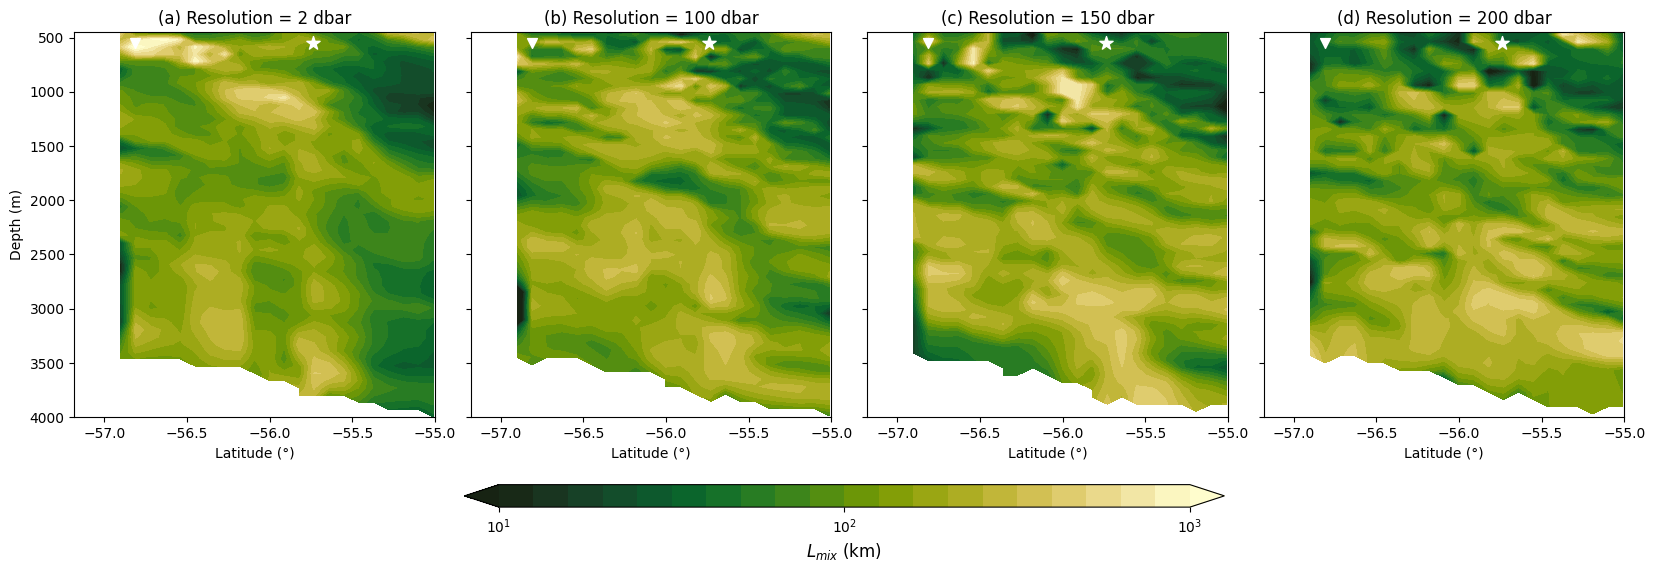

In [52]:
import matplotlib.pyplot as plt
import cmocean as cmo

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20, 5), sharey=True)
levels = np.arange(4, 6.01, 0.1)
cmap = cmo.cm.speed_r

im1 = ax1.contourf(lat_section, depth_section, np.log10(abs(ds_section_depth.Lmix)), cmap=cmap, levels = levels,extend='both')
im2 = ax2.contourf(lat_section_sub100, depth_section_sub100, np.log10(abs(ds_section_depth_sub100.Lmix)), cmap=cmap, levels = levels,extend='both')
im3 = ax3.contourf(lat_section_sub150, depth_section_sub150, np.log10(abs(ds_section_depth_sub150.Lmix)), cmap=cmap, levels = levels,extend='both')
im4 = ax4.contourf(lat_section_sub200, depth_section_sub200, np.log10(abs(ds_section_depth_sub200.Lmix)), cmap=cmap, levels = levels,extend='both')

for ax in [ax1,ax2,ax3,ax4]:
    ax.scatter(PF_lat_SR1b, 550, marker='v', color='w', s=50, zorder=10)
    ax.scatter(SAF_lat_SR1b, 550, marker='*', color='w', s=100, zorder=10)
    ax.set_xlim(-57.18,-55)
    ax.set_ylim(450,4000)
    ax.invert_yaxis()
    ax.set_xlabel('Latitude (°)')
ax1.set_ylabel('Depth (m)')

ax1.set_title(r'(a) Resolution = 2 dbar')
ax2.set_title(r'(b) Resolution = 100 dbar')
ax3.set_title(r'(c) Resolution = 150 dbar')
ax4.set_title(r'(d) Resolution = 200 dbar')

cbar_ax1 = fig.add_axes([0.32, -0.07, 0.38, 0.045])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', ticks=[4,5,6])
cbar1.ax.set_xticklabels([r'$10^{1}$',r'$10^{2}$',r'$10^{3}$'])
cbar1.ax.set_xlabel(r'$L_{mix}$ (km)',fontsize=12)

plt.subplots_adjust(wspace=0.1)

plt.savefig('figures_paper/section_vertical_res.pdf', bbox_inches='tight')
plt.show()